```{index} single: application; portfolio
```
```{index} single: application; investment
```
```{index} single: solver; cplex
```

# Markowitz portfolio optimization

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and ipopt, then sets SOLVER to 
use the ipopt solver. If run elsewhere, it assumes Pyomo and the Mosek solver have been previously installed and sets SOLVER to use the Mosek solver via the Pyomo SolverFactory. In both cases it then verifies that SOLVER is available.

In [1]:
import sys, os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    solver = "ipopt"
else:
    solver = "mosek_direct"

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"Solver {solver} is not available."

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Problem description and model formulation

A canonical stochastic optimization problem is the so-called portfolio selection problem, also known as **Markowitz portfolio optimization**. Assume that an investor has an initial capital $C$ that she wants to invest in $n$ possible risky assets, each of them with an unknown return rate $r_i$, $i=1,\dots,n$, or in another risk-free asset with a guaranteed return rate $R$. Let $x$ be the vector whose $i$-th component $x_i$ describes the amount invested in asset $i$ and $\tilde{x}$ the amount invested in the risk-free asset. We consider a stochastic model in which the return of the $n$ risky assets is then a random vector $r$ with known expected values $\mu = \mathbb E r $ and covariance

$$
    \Sigma = \mathbb{E} [ (r-\mu)(r-\mu)^\top].
$$

The investment return $y = R \tilde{x} + r^\top x$ then becomes also a random variable with mean

$$
    \mathbb{E} y = R \tilde{x} + \mathbb{E} r^\top x = R \tilde{x} + \mu^\top x
$$

and variance

$$
    \mathrm{Var}(y) = \mathbb{E}(y-\mathbb{E}y)^2 = x^\top \Sigma x.
$$

The variance of the investment return is a possible way to quantify the risk of the investment $x$.

The investor needs to select a portfolio that achieves a good compromise between risk and expected return. One could try to maximize the expected return $\mathbb{E} y$ subject to an upper bound on the tolerable risk, obtaining the following optimization problem:

$$
\begin{align*}
    \max \quad  & R \tilde{x} + \mu^\top x \\
    \text{s.t.}\quad
    & \sum_{i=1}^n x_i + \tilde{x}  = C  \\
    & x^\top \Sigma x \leq \gamma \\
    & \tilde{x} \geq 0 \\
    & x_i \geq 0 & \forall \, i=1,\dots,n.
\end{align*}
$$

The first constraint describes the fact that the total amount invested must be equal to the initial capital. The second constraint ensures that the variance of the chosen portfolio is upper bounded by a parameter $\gamma$, which captures the risk the investor is willing to take. The last non-negativity constraint excludes the possibility of short-selling.

One can easily show that the quadratic constraint $x^\top \Sigma x \leq \gamma$ is convex in $x$ due to the fact that $\Sigma$ is positive semi-definite, being a covariance matrix. Therefore, the optimization problem is convex. Let us implement it in Pyomo and solve it.

In [3]:
def markowitz(gamma, mu, Sigma):
    m = pyo.ConcreteModel("Markowitz portfolio optimization")

    m.xtilde = pyo.Var(domain=pyo.NonNegativeReals)
    m.x = pyo.Var(range(n), domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return mu @ m.x + R * m.xtilde

    @m.Constraint()
    def bounded_variance(m):
        return (m.x @ (Sigma @ m.x)) <= gamma

    @m.Constraint()
    def total_assets(m):
        return sum(m.x[i] for i in range(n)) + m.xtilde == C

    SOLVER.solve(m)

    return m

We now calculate the optimal investment strategy for a portfolio with $n=3$ assets, with expected returns $\mu = (1.2, 1.1, 1.3)$ and a predefined covariance matrix. We set the risk parameter $\gamma$ to $1$ and the risk-free return rate $R$ to $1.01$.

In [4]:
# Specify the initial capital, the risk threshold, and the guaranteed return rate.
C = 1
gamma = 1
R = 1.01

# Specify the number of assets, their expected return, and their covariance matrix.
n = 3
mu = np.array([1.2, 1.1, 1.3])
Sigma = np.array([[1.5, 0.5, 2], [0.5, 2, 0], [2, 0, 5]])

# Check that Sigma is semi-definite positive
assert np.all(np.linalg.eigvals(Sigma) >= 0)

# When changing the matrix Sigma, make sure to input a semi-definite positive matrix.
# The easiest way to generate a random covariance matrix is as follows:
# first generate a random m x m matrix A and than take the matrix A A^T
# which is always semi-definite positive by construction.
#
# m = 3
# A = np.random.rand(m, m)
# Sigma = A.T @ A

m = markowitz(gamma, mu, Sigma)

print(
    f"Optimal solution: xtilde = {m.xtilde.value:.3f}, x_1 = {m.x[0].value:.3f}, x_2 = {m.x[1].value:.3f}, x_3 = {m.x[2].value:.3f}"
)
print(f"Optimal investment return: {m.objective():.2f}")

Optimal solution: xtilde = 0.158, x_1 = 0.561, x_2 = 0.142, x_3 = 0.139
Optimal investment return: 1.17


The next plot shows how the objective function changes as the risk threshold parameter $\gamma$ varies.

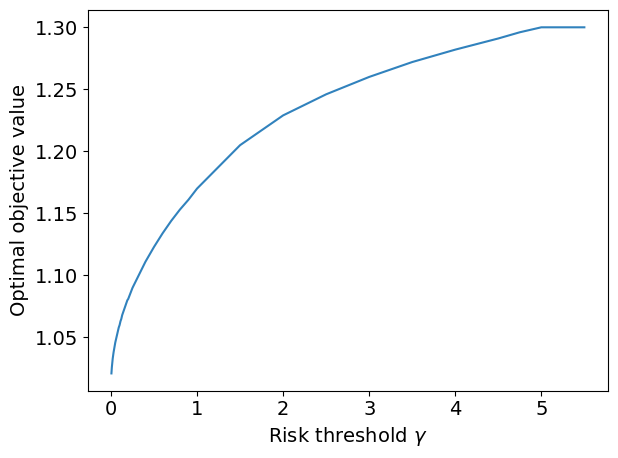

In [5]:
gamma_values = np.linspace(0, 5, 100)
objective = []

plt.rcParams.update({"font.size": 14})
for gamma in gamma_values:
    m = markowitz(gamma, mu, Sigma)
    objective.append(round(m.objective(), 3))

plt.plot(gamma_values, objective, color=plt.cm.tab20c(0))
plt.xlabel(r"Risk threshold $\gamma$")
plt.ylabel("Optimal objective value")
plt.tight_layout()
plt.show()